# Analyzing the results of regular Logistic Regression CV against the single-pathway upsampling strategy synthetic datasets

## I. Unpack results.

In [1]:
%pylab inline
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib_venn import venn3, venn3_circles, venn2
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

repo_path = '/Users/alex/Documents/gslr/'
KEGG_path = repo_path + 'experiments/KEGG/KEGG_df.filtered.with_correlates.pickle'

# File was serialized like so: 
#   results = {pathway_id: (scores, features) for (pathway_id, scores, features) in results}
#   pickle.dump(results, open('results.pickle', 'wb'))

results = pickle.load(open('logit_results.pickle', 'rb'))

Populating the interactive namespace from numpy and matplotlib


In [2]:
scores = pd.DataFrame({pathway_id: scores[0].flatten().tolist() for pathway_id, scores, chosen_genes in results})
features = {pathway: features for pathway, scores, features in results}

## II. Analyze test-accuracy across folds (k = 10)

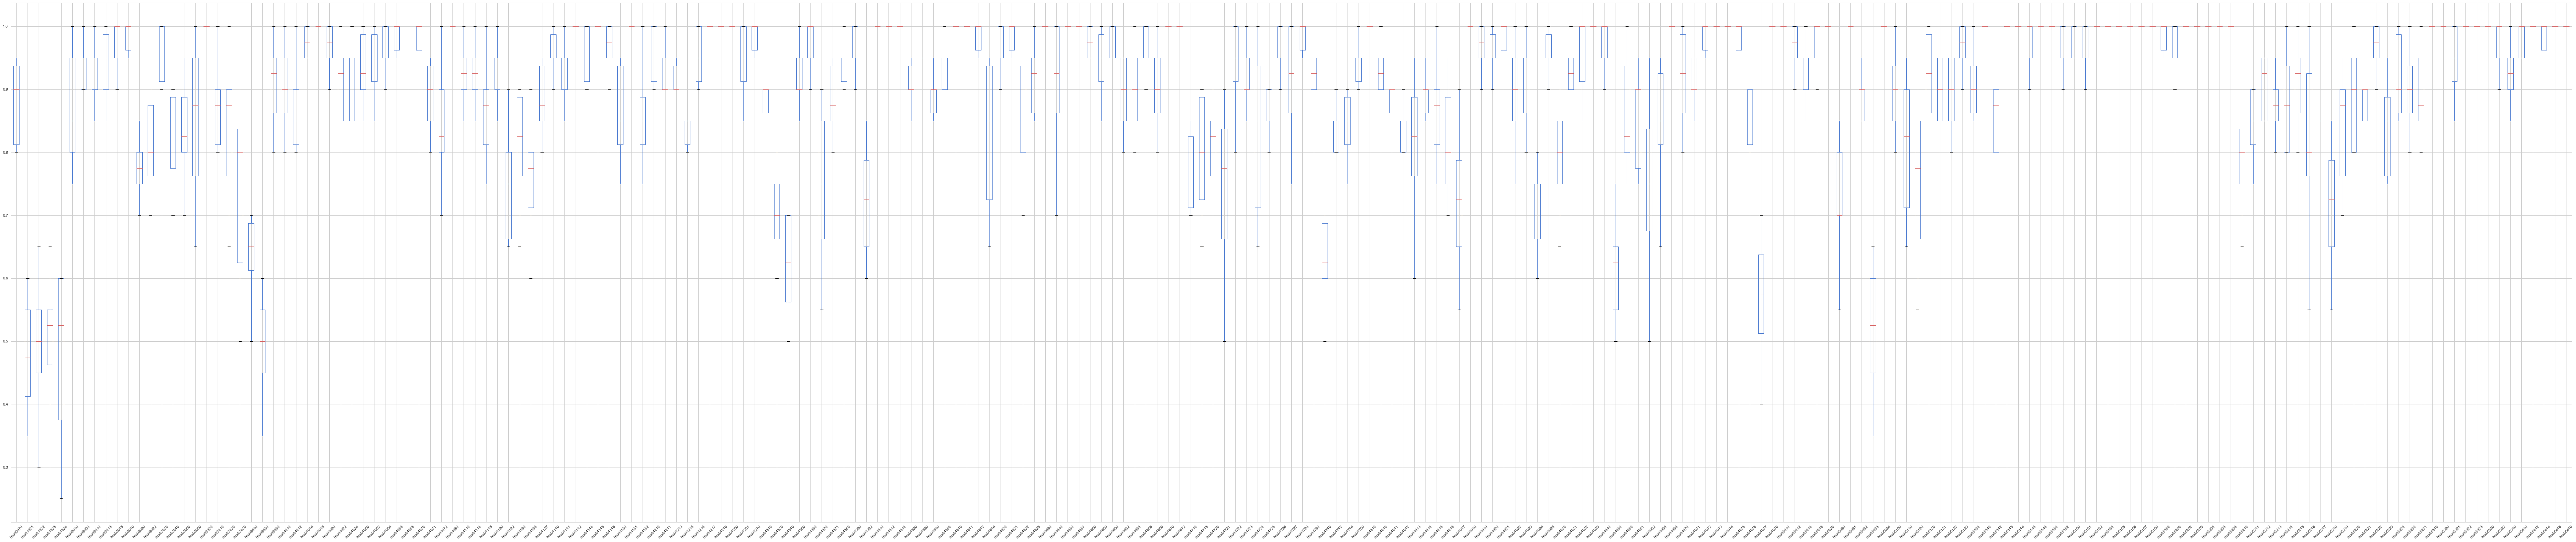

In [3]:
scores.plot.box(figsize=(120,25), rot=45)#.get_figure().savefig("/Users/alex/Desktop/logit_results.png")

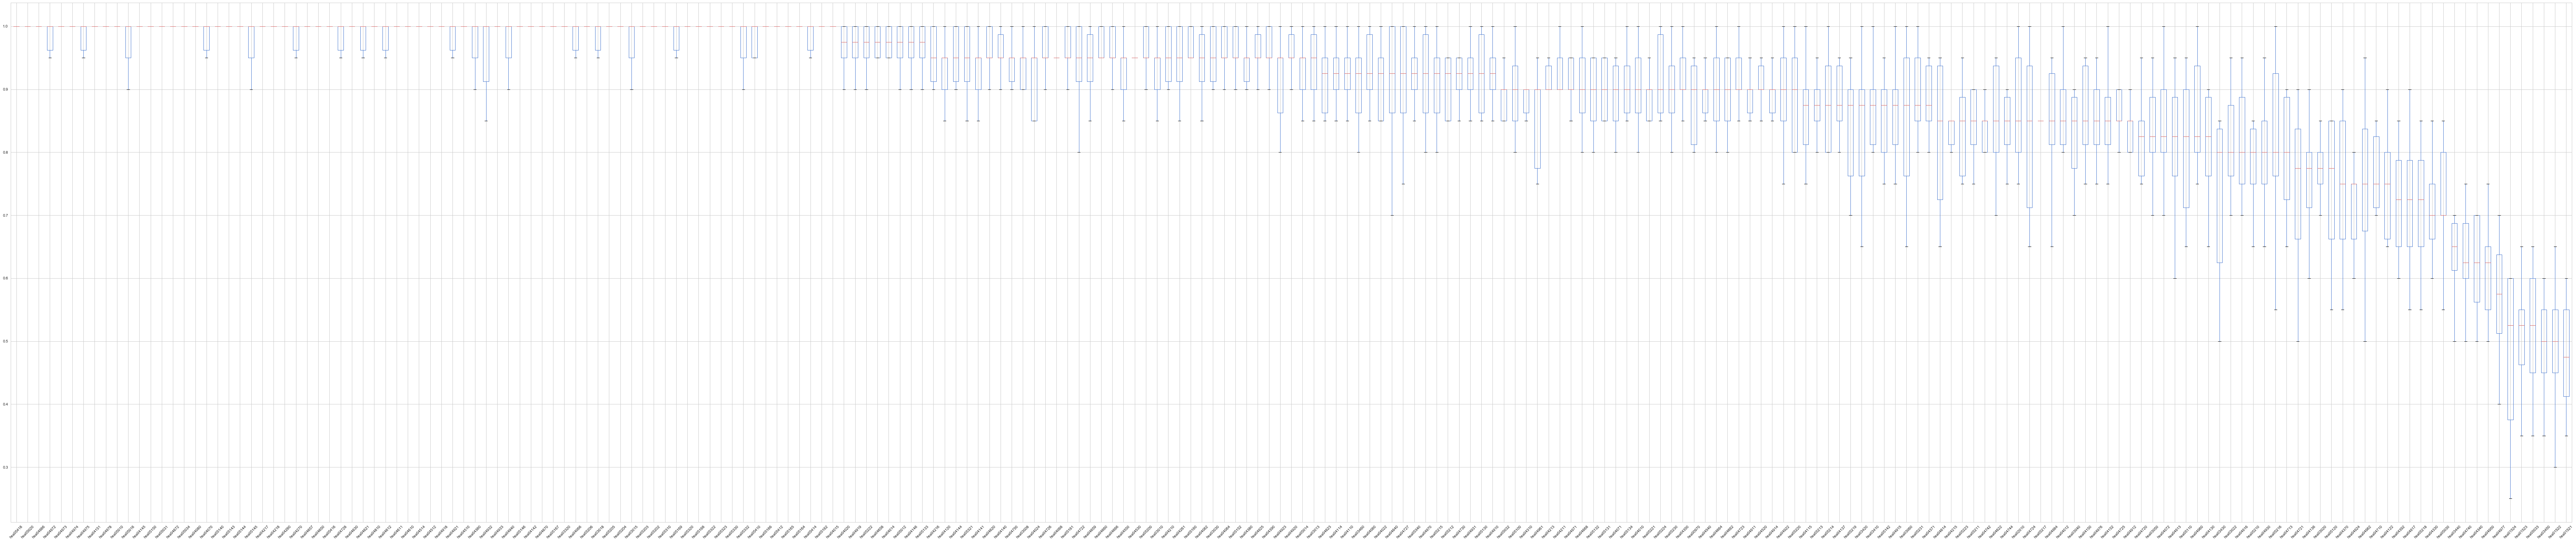

In [4]:
scores[scores.median().sort_values(ascending=False).index].plot.box(figsize=(120,25), rot=45)#.get_figure().savefig("/Users/alex/Desktop/logit_results_sorted.png")

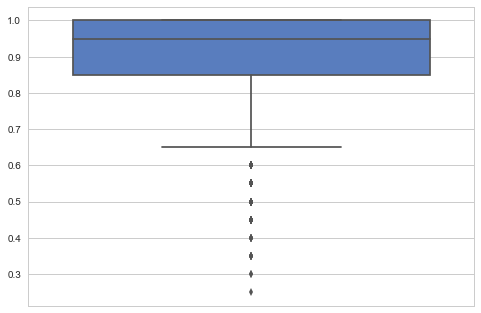

In [5]:
sns.boxplot(y=pd.melt(scores)['value'].tolist())

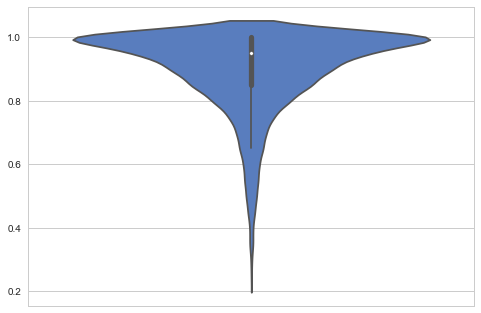

In [6]:
sns.violinplot(y=pd.melt(scores)['value'].tolist())
# sns.swarmplot(y=pd.melt(scores)['value'].tolist(), color="white", edgecolor="gray")

In [7]:
means = scores.mean()
np.mean(means.values), np.std(means.values)

(0.90034934497816599, 0.10920358881288936)

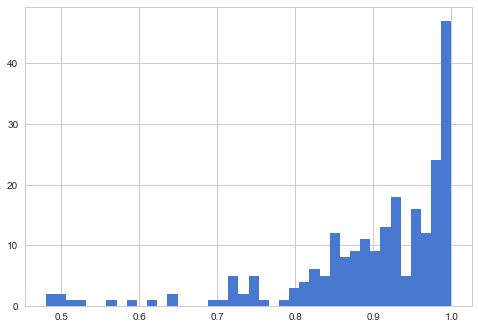

In [8]:
means.hist(bins=40)

## III. Analyze pathway recovery

In [9]:
pathways_df = pd.read_pickle(KEGG_path)

pathways = {pathway_id: pathways_df.loc[pd.IndexSlice[:, :, [pathway_id]],['genes', 'correlates']].values[0][0] for pathway_id in pathways_df.index.get_level_values(2)}

In [10]:
set(pathways.keys()) == set(features.keys())

True

In [11]:
features = {key: (set(pathways[key]), set(features[key])) for key in (set(pathways.keys()) & set(features.keys()))}

In [12]:
pair = list(features.items())[0][1]

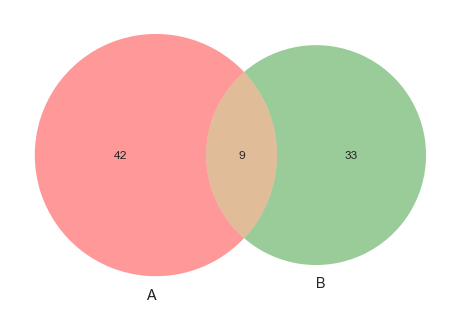

In [13]:
venn2([pair[0], pair[1]])

In [14]:
def recall(truth, pred):    
    return len(truth & pred) / float(len(truth))
    
def precision(truth, pred):
    return len(truth & pred) / float(len(pred))


### Turns out some of the pathways have no true genes. See below:

In [15]:
{pathway: (len(truth), len(pred)) for pathway, (truth, pred) in features.items()}

{'hsa00970': (66, 107),
 'hsa01521': (0, 159),
 'hsa01522': (0, 162),
 'hsa01523': (0, 159),
 'hsa01524': (0, 162),
 'hsa02010': (44, 112),
 'hsa03008': (101, 99),
 'hsa03010': (153, 99),
 'hsa03013': (171, 112),
 'hsa03015': (91, 94),
 'hsa03018': (78, 83),
 'hsa03020': (31, 127),
 'hsa03022': (45, 128),
 'hsa03030': (36, 100),
 'hsa03040': (134, 120),
 'hsa03050': (45, 119),
 'hsa03060': (23, 108),
 'hsa03320': (72, 41),
 'hsa03410': (33, 102),
 'hsa03420': (47, 129),
 'hsa03430': (23, 133),
 'hsa03440': (41, 113),
 'hsa03450': (13, 157),
 'hsa03460': (54, 99),
 'hsa04010': (255, 115),
 'hsa04012': (86, 124),
 'hsa04014': (227, 65),
 'hsa04015': (210, 77),
 'hsa04020': (182, 69),
 'hsa04022': (163, 104),
 'hsa04024': (198, 93),
 'hsa04060': (270, 90),
 'hsa04062': (185, 108),
 'hsa04064': (95, 93),
 'hsa04066': (99, 67),
 'hsa04068': (131, 105),
 'hsa04070': (99, 86),
 'hsa04071': (118, 99),
 'hsa04072': (146, 121),
 'hsa04080': (277, 67),
 'hsa04110': (124, 73),
 'hsa04114': (124, 9

In [16]:
summary = {pathway: (recall(truth, pred), precision(truth, pred)) for pathway, (truth, pred) in features.items()  if len(truth) > 0}
summary = pd.DataFrame(summary, index=['recall', 'precision'])
summary

,hsa00970,hsa02010,hsa03008,hsa03010,hsa03013,hsa03015,hsa03018,hsa03020,hsa03022,hsa03030,...,hsa05322,hsa05323,hsa05330,hsa05332,hsa05340,hsa05410,hsa05412,hsa05414,hsa05416,hsa05418
recall,0.181818,0.181818,0.118812,0.052288,0.076023,0.054945,0.089744,0.129032,0.222222,0.194444,...,0.06015,0.100000,0.157895,0.243902,0.135135,0.144578,0.166667,0.133333,0.135593,0.064748
precision,0.112150,0.071429,0.121212,0.080808,0.116071,0.053191,0.084337,0.031496,0.078125,0.070000,...,0.32000,0.147541,0.146341,0.128205,0.054348,0.187500,0.153846,0.166667,0.145455,0.243243


In [17]:
summary.mean(axis=1)

recall       0.119408
precision    0.119747
dtype: float64

In [18]:
summary.std(axis=1)

recall       0.067230
precision    0.062038
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11927ad30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1192df8d0>]], dtype=object)

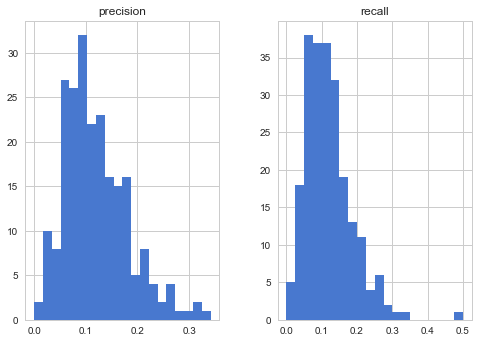

In [19]:
summary.transpose().hist(bins=20)